# ***Импорт библиотек***

In [1]:
!pip3 install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer #лемматизация и стемминг уже внутри вшиты
import pandas as pd
from sqlalchemy import create_engine
from catboost import CatBoostClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN


# Создаем датасет с лайками пользователей и вытаскиваем фитчи из взаимодействий

In [ ]:
# Создадим переменную connection_path для того чтобы подключаться к базе данных не указывая явно в коде логин и пароль от БД

config_file = "config.txt"
with open(config_file, "r") as f:
    config_data = f.readlines()

config = {}
for line in config_data:
    key, value = line.strip().split("=")
    config[key] = value
    
connection_path = f"postgresql://{config['username']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

In [3]:
def get_data_from_sql(query:str):
    conn_uri = connection_path
    df = pd.read_sql(query, conn_uri)
    return df

In [4]:
def save_data_to_sql(df:DataFrame, table_name: str):
    
    engine = create_engine(connection_path)

    df.to_sql(table_name, con=engine, index=False, if_exists='replace')

In [5]:
query_post_seen_and_liked_by_user = '''
    SELECT
        f.user_id,
        p.topic,
        COUNT(CASE WHEN f.action = 'view' THEN 1 ELSE NULL END) AS seen_posts,
        COUNT(CASE WHEN f.action = 'like' THEN 1 ELSE NULL END) AS liked_posts
    FROM
        public.feed_data AS f
    JOIN
        public.post_text_df AS p ON f.post_id = p.post_id
    GROUP BY
        f.user_id, p.topic
'''
df_most_liked_posts_by_topic = get_data_from_sql(query_post_seen_and_liked_by_user)

In [6]:
# Группировка данных по 'user_id' и выбор топ-3 для каждой группы
top_3_per_user = df_most_liked_posts_by_topic.sort_values(by='liked_posts', ascending=False).groupby('user_id').head(3)
# Создание новой колонки 'top_3' с темами
df_most_liked_posts_by_topic['top_3'] = top_3_per_user.groupby('user_id')['topic'].agg(list).reindex(df_most_liked_posts_by_topic['user_id']).tolist()

In [7]:
df_most_liked_posts_by_topic.head(8)

,user_id,topic,seen_posts,liked_posts,top_3
0,200,business,28,2,"[movie, covid, sport]"
1,200,covid,93,9,"[movie, covid, sport]"
2,200,entertainment,14,4,"[movie, covid, sport]"
3,200,movie,88,15,"[movie, covid, sport]"
4,200,politics,58,4,"[movie, covid, sport]"
5,200,sport,64,7,"[movie, covid, sport]"
6,200,tech,13,2,"[movie, covid, sport]"
7,201,business,29,3,"[movie, covid, tech]"


In [8]:
query_likes_by_user = '''
    SELECT p.user_id, ARRAY_AGG(DISTINCT p.post_id) AS liked_posts
    FROM public.feed_data AS p
    WHERE p.target = 1
    GROUP BY p.user_id
'''
df_liked_posts = get_data_from_sql(query_likes_by_user)

In [9]:
# df_most_liked_posts_by_topic нет дубликатов по 'user_id'
df_most_liked_posts_by_topic_ = df_most_liked_posts_by_topic.drop_duplicates(subset='user_id').copy()
# выполните мердж
df_liked_posts = pd.merge(df_liked_posts, df_most_liked_posts_by_topic_[['user_id', 'top_3']], on='user_id', how='left')

In [10]:
df_liked_posts.head(2)

,user_id,liked_posts,top_3
0,200,"[249, 472, 668, 783, 805, 860, 992, 994, 1198,...","[movie, covid, sport]"
1,201,"[48, 129, 154, 649, 680, 863, 936, 1244, 1555,...","[movie, covid, tech]"


In [11]:
save_data_to_sql(df_liked_posts,'koryakovda_features_users_actions')

# ***Загрузка и обработка фитчей и выгрузка для таблицы user***

In [12]:
def users_average_age_per_city(df):
    av_age = df_user_data.groupby('city')['age'].mean()
    df['av_age_per_city'] = df['city'].map(av_age)
    return df

In [13]:
def count_users_in_country(df):
    count = df['country'].value_counts()  # Count the number of users in each country
    df['users_in_country'] = df['country'].map(count)  # Map the counts back to the original DataFrame
    return df

In [14]:
def user_age_split(df):
    bins = [0, 12, 17, 24, 34, 44, 54, 64, float('inf')]  # Определение границ бинов
    labels = ['Дети','Подростки', 'Молодежь', 'Молодые взрослые', 'Взрослые', 'Средний возраст', 'Старшее поколение', 'Пожилые']  # Названия групп
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    
    return df

In [15]:
def user_feature_creation(df):
    df = user_age_split(df)
    df = count_users_in_country(df)
    df = users_average_age_per_city(df)
    
    return df

In [16]:
df_user_data = get_data_from_sql("SELECT * FROM public.user_data")

In [17]:
df_user_data = user_feature_creation(df_user_data)

In [18]:
df_user_data.head(2)

,user_id,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city
0,200,1,34,Russia,Degtyarsk,3,Android,ads,Взрослые,143035,25.600000
1,201,0,37,Russia,Abakan,0,Android,ads,Взрослые,143035,27.672199


In [19]:
save_data_to_sql(df_user_data,'koryakovda_features_users')

## ***Загрузка и обработка фитчей и выгрузка для таблицы posts***

In [20]:
def tfidf_vectorization(df: pd.DataFrame, to_vector: str):    

    tfidf = TfidfVectorizer()
    
    # Объединяем все тексты в один корпус
    corpus = df[to_vector]

    # Применяем TfidfVectorizer к корпусу
    tfidf_matrix = tfidf.fit_transform(corpus)
    tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # Создаем фичи суммы, среднего и минимума по TFIDF до PCA
    df['tfidf_sum'] = tfidf_matrix.sum(axis=1)
    df['tfidf_mean'] = tfidf_matrix.mean(axis=1)
    df['tfidf_max'] = tfidf_matrix.max(axis=1)

    return df

In [21]:
from sklearn.metrics import pairwise_distances

def make_post_clasterisation(df):    
    tfidf = TfidfVectorizer()
    n_components_pca = 20
    n_components_kmeans = 16

    # Объединяем все тексты в один корпус
    corpus = df_post_text['text']
    tfidf_matrix = tfidf.fit_transform(corpus)
    tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    pca = PCA(n_components=n_components_pca, random_state=42)
    embedded_features_pca = pca.fit_transform(tfidf_matrix)

    kmeans = KMeans(n_clusters=n_components_kmeans, random_state=42)
    kmeans.fit(embedded_features_pca)
    
    # Добавляем метки кластеров к DataFrame
    df['kmeans_labels'] = kmeans.labels_

    # Получаем координаты центров кластеров в исходной форме
    tfidf_centers = kmeans.cluster_centers_

    # Рассчитываем расстояния
    distances = pairwise_distances(embedded_features_pca, tfidf_centers, metric='euclidean')

    # Добавляем расстояния в DataFrame
    for i in range(n_components_kmeans):
        df_post_text[f'distance_to_cluster_{i}'] = distances[:, i]


    return df


In [22]:
def post_feature_creation(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df = tfidf_vectorization(df, to_vector = 'text')
    df = make_post_clasterisation(df)
    return df

In [23]:
df_post_text = get_data_from_sql("SELECT * FROM public.post_text_df")

In [24]:
df_post_text = post_feature_creation(df_post_text)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
df_post_text.head(2)

,post_id,text,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,...,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15
0,1,UK economy facing major risks\n\nThe UK manufa...,business,324,10.593563,0.000204,0.439495,13,0.400397,0.506934,...,0.454413,0.342633,0.438547,0.571169,0.374431,0.377767,0.422268,0.116985,0.463383,0.572343
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,448,13.535486,0.000261,0.290946,7,0.317174,0.462388,...,0.280911,0.161058,0.370910,0.528209,0.234819,0.283003,0.354002,0.238487,0.400994,0.527602


In [26]:
save_data_to_sql(df_post_text, 'koryakovda_features_post')

# ***Обучение модели***

In [27]:
def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(connection_path)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


def load_features() -> pd.DataFrame:
    query = 'SELECT * FROM public.feed_data LIMIT 2000000'
    return batch_load_sql(query)

In [28]:
# Выгружаем табличку взаимодействий (размер корректируем для обучения)
user_post_iteractions = load_features()

In [29]:
user_post_iteractions.head(3)

,timestamp,user_id,post_id,action,target
0,2021-11-10 20:44:52,93408,2888,view,0
1,2021-11-10 20:45:24,93408,3000,view,0
2,2021-11-10 20:47:46,93408,1685,view,0


In [30]:
# Выгружаем обработанные таблички из SQL
features_users_df = get_data_from_sql("SELECT * FROM koryakovda_features_users")
features_post_df = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_users_actions_df = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")

In [31]:
# Обьединяем датасеты в один большой для исследования
def create_dataset(user_post_iteractions, features_users_df, features_post_df, features_users_actions_df):
    step_one = pd.merge(user_post_iteractions, features_users_df, on='user_id')
    step_two = pd.merge(step_one, features_post_df, on='post_id')
    step_three = pd.merge(step_two, features_users_actions_df[['user_id', 'top_3']], on='user_id')

    return step_three

In [32]:
dataset = create_dataset(user_post_iteractions,features_users_df,features_post_df,features_users_actions_df)

***Добавление новых фитчей в итоговый датасет на основе временных данных***

In [33]:
# Выделение часа и дня недели  - предположение что в зависимости от дня недели и часа дня утро\день\вечер - человека интересуюр разные потсы
def create_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['month'] = df['timestamp'].dt.month
    return df

In [34]:
dataset = create_time_features(dataset)

***Построим графики нашего предположения - изменение отношения показов поста к количеству лайков от дня недели и часа дня***

/tmp/ipykernel_34/762268696.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(grouped_data, values='count', index=['topic', 'day_of_week'], columns='action', fill_value=0)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a leng

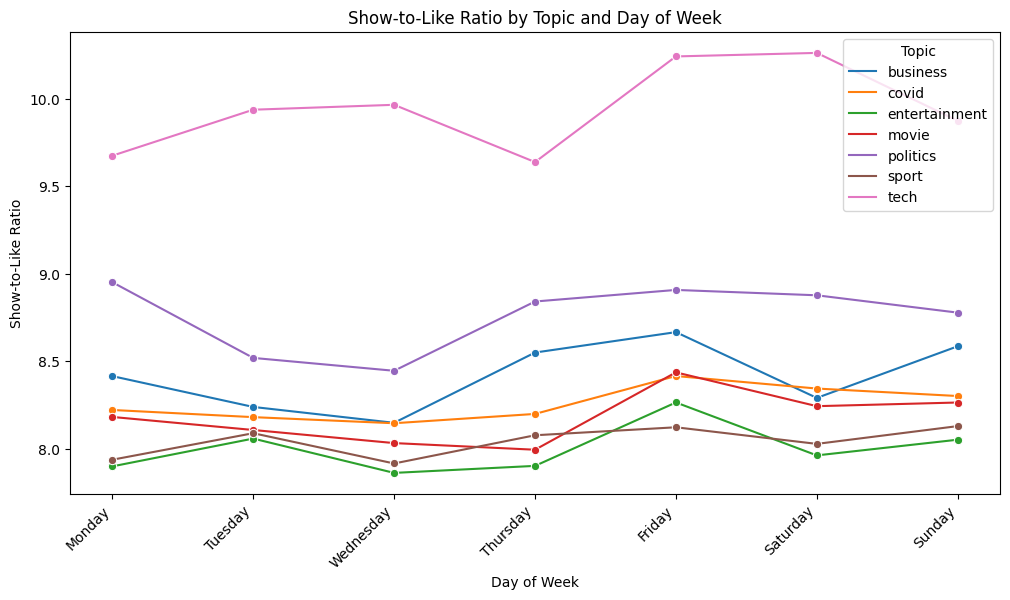

In [35]:
def plot_show_like_ratio_by_day(df, days_order=None):
    # Группировка данных по теме, дню недели и подсчет количества показанных и лайкнутых постов
    grouped_data = df.groupby(['topic', 'day_of_week', 'action']).size().reset_index(name='count')

    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Указание порядка дней недели
    grouped_data['day_of_week'] = pd.Categorical(grouped_data['day_of_week'], categories=days_order, ordered=True)

    # Создание сводной таблицы с количеством показанных и лайкнутых постов по темам и дням недели
    pivot_table = pd.pivot_table(grouped_data, values='count', index=['topic', 'day_of_week'], columns='action', fill_value=0)

    # Вычисление отношения количества показанных постов к количеству лайкнутых постов
    pivot_table['view_like_ratio'] = pivot_table['view'] / pivot_table['like']

    # Построение графика
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='day_of_week', y='view_like_ratio', hue='topic', data=pivot_table.reset_index(), marker='o')
    plt.title('Show-to-Like Ratio by Topic and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Show-to-Like Ratio')
    plt.legend(title='Topic', loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Пример использования функции с вашим датасетом

plot_show_like_ratio_by_day(dataset, days_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

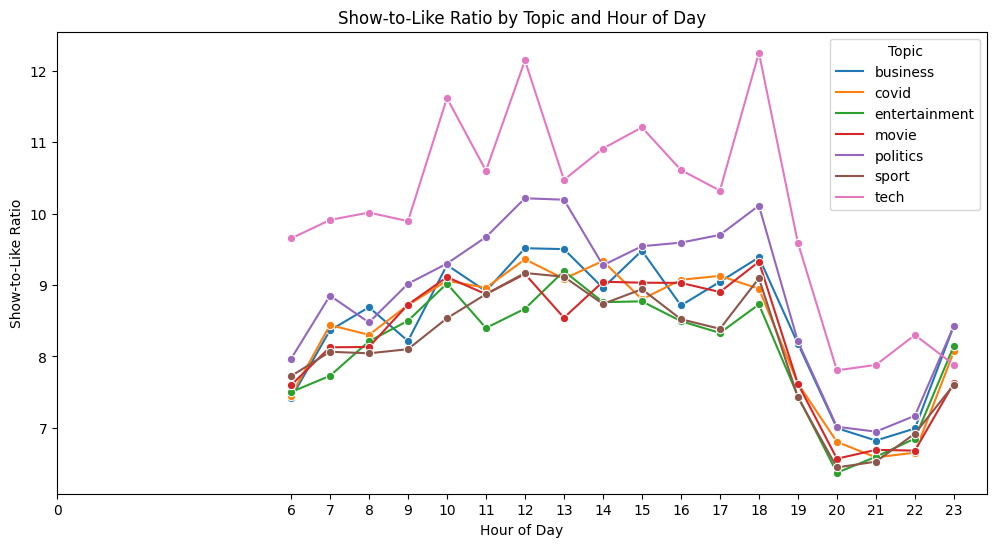

In [36]:
def plot_show_like_ratio_by_hour(df):
    # Группировка данных по теме, часу дня и подсчет количества показанных и лайкнутых постов
    grouped_data = df.groupby(['topic', 'hour', 'action']).size().reset_index(name='count')

    # Создание сводной таблицы с количеством показанных и лайкнутых постов по темам и часам дня
    pivot_table = pd.pivot_table(grouped_data, values='count', index=['topic', 'hour'], columns='action', fill_value=0)

    # Вычисление отношения количества показанных постов к количеству лайкнутых постов
    pivot_table['view_like_ratio'] = pivot_table['view'] / pivot_table['like']

    # Построение графика
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='hour', y='view_like_ratio', hue='topic', data=pivot_table.reset_index(), marker='o')
    plt.title('Show-to-Like Ratio by Topic and Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Show-to-Like Ratio')
    plt.legend(title='Topic', loc='upper right')
    plt.xticks(grouped_data['hour'].unique())  
    plt.show()

plot_show_like_ratio_by_hour(dataset)


In [37]:
pd.set_option('display.max_columns', None)
dataset.head(2)
# pd.reset_option('display.max_columns')

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,text,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month
0,2021-11-10 20:44:52,93408,2888,view,0,0,16,Russia,Rostov,3,Android,ads,Подростки,143035,27.018819,Remember to regularly wash your hands for at l...,covid,21,4.182368,0.000081,0.410489,1,0.489497,0.103112,0.339327,0.383572,0.390335,0.383612,0.538714,0.422740,0.409225,0.290682,0.412585,0.391828,0.280859,0.472339,0.416882,0.273804,"{movie,covid,sport}",20,Wednesday,11
1,2021-11-10 20:45:24,93408,3000,view,0,0,16,Russia,Rostov,3,Android,ads,Подростки,143035,27.018819,You know things are fucked up when news of #Ka...,covid,21,3.888979,0.000075,0.396274,1,0.455166,0.152673,0.327242,0.375805,0.392636,0.357690,0.525226,0.400677,0.403372,0.312757,0.404364,0.388708,0.281631,0.450047,0.402748,0.297416,"{movie,covid,sport}",20,Wednesday,11


***Подготовка к построению модели***

In [38]:
# Модель будем строить по столбцу target поэтому сразу удаляем из датасета взаимодействия-повторы где like target = 0 (там view = 1)
dataset = dataset[dataset['action'] != 'like']
dataset.head(2)

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,text,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month
0,2021-11-10 20:44:52,93408,2888,view,0,0,16,Russia,Rostov,3,Android,ads,Подростки,143035,27.018819,Remember to regularly wash your hands for at l...,covid,21,4.182368,0.000081,0.410489,1,0.489497,0.103112,0.339327,0.383572,0.390335,0.383612,0.538714,0.422740,0.409225,0.290682,0.412585,0.391828,0.280859,0.472339,0.416882,0.273804,"{movie,covid,sport}",20,Wednesday,11
1,2021-11-10 20:45:24,93408,3000,view,0,0,16,Russia,Rostov,3,Android,ads,Подростки,143035,27.018819,You know things are fucked up when news of #Ka...,covid,21,3.888979,0.000075,0.396274,1,0.455166,0.152673,0.327242,0.375805,0.392636,0.357690,0.525226,0.400677,0.403372,0.312757,0.404364,0.388708,0.281631,0.450047,0.402748,0.297416,"{movie,covid,sport}",20,Wednesday,11


In [39]:
# Сортируем датасет для дальнейшего деления на трейн и тест по timestamp
dataset = dataset.sort_values(by = 'timestamp')
dataset.head(2)

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,text,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month
118706,2021-10-01 06:01:40,1859,1498,view,1,0,19,Ukraine,Kyiv,3,Android,ads,Молодежь,8273,27.065896,Chelsea clinch cup in extra-time\n\n(after ext...,sport,592,14.081849,0.000272,0.237964,4,0.337872,0.359962,0.263545,0.306005,0.138119,0.273519,0.427372,0.290666,0.335862,0.445166,0.342981,0.289684,0.254605,0.373133,0.355264,0.449956,"{movie,sport,covid}",6,Friday,10
1591534,2021-10-01 06:01:52,14244,1411,view,0,0,18,Russia,Saratov,2,Android,ads,Молодежь,143035,27.428179,McLeish ready for criticism\n\nRangers manager...,sport,176,8.633342,0.000167,0.461798,4,0.354401,0.396419,0.307094,0.332098,0.184356,0.326939,0.447274,0.289954,0.377596,0.480482,0.353835,0.348269,0.322995,0.393457,0.377488,0.501576,"{movie,covid,sport}",6,Friday,10


In [40]:
# Выделяем категориальный фитчи
cat_features = ['gender','country','city','exp_group','os','source','age_group','topic','kmeans_labels','day_of_week','hour', 'month', 'top_3']

In [41]:
# Делим на трейн и тест выделив для трейна 80% и теста 20% выборки
num_rows = int(len(dataset) * 0.2)
train_set = dataset.iloc[:-num_rows]
test_set = dataset.iloc[-num_rows:]

In [42]:
# Создадим список для каждого юзера с постами которые были лайкнуты на трейне чтобы удалить их на тесте чтобы модель их не рекомендовала. 
# т.к. рекоменовать человеку снова что-то уже лайкнутое в трейне как будто не логично (подглядываем в ответ)
liked_posts_by_users_train = train_set[train_set['target'] == 1][['user_id', 'post_id']].drop_duplicates()

In [43]:
# Уберем из теста лайкнутые в трейне посты
merged_data = test_set.merge(liked_posts_by_users_train, on=['user_id', 'post_id'], how='left', indicator=True)
filtered_test_set = merged_data[merged_data['_merge'] == 'left_only']
filtered_test_set = filtered_test_set.drop(columns=['_merge'])

In [44]:
filtered_test_set.head(2)

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,text,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month
0,2021-12-11 18:25:25,2037,1098,view,0,0,30,Russia,Izhevsk,2,Android,ads,Молодые взрослые,143035,27.163438,Police urge pub closure power\n\nNew powers ar...,politics,507,13.359053,0.000258,0.286002,7,0.287129,0.450644,0.247211,0.326115,0.277097,0.291791,0.256691,0.106087,0.329357,0.526621,0.269382,0.302160,0.329222,0.352913,0.358232,0.505011,"{movie,covid,politics}",18,Saturday,12
1,2021-12-11 18:25:26,58870,2649,view,0,1,24,Russia,Yershov,1,Android,ads,Молодые взрослые,143035,24.666667,We are in challenging times because of #COVID1...,covid,23,4.067590,0.000078,0.517439,1,0.538966,0.321253,0.453916,0.468722,0.465146,0.472011,0.607625,0.489147,0.501854,0.430257,0.491051,0.507893,0.417414,0.531067,0.499396,0.418567,"{movie,covid,entertainment}",18,Saturday,12


***Работа по предсказанию***

In [45]:
# поделим данные на фитчи и таргет
X_train = train_set.drop('target', axis=1)
X_test = filtered_test_set.drop('target', axis=1)

y_train = train_set['target']
y_test = filtered_test_set['target']

In [46]:
# Удаляем ненужные стлобцы, создаем новый датасет для работы
X_train_cut = X_train.drop(['timestamp','text','user_id','post_id','action'],axis =1)
X_test_cut = X_test.drop(['timestamp','text','user_id','post_id','action'],axis =1)

In [47]:
X_train_cut.head(2)

,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month
118706,0,19,Ukraine,Kyiv,3,Android,ads,Молодежь,8273,27.065896,sport,592,14.081849,0.000272,0.237964,4,0.337872,0.359962,0.263545,0.306005,0.138119,0.273519,0.427372,0.290666,0.335862,0.445166,0.342981,0.289684,0.254605,0.373133,0.355264,0.449956,"{movie,sport,covid}",6,Friday,10
1591534,0,18,Russia,Saratov,2,Android,ads,Молодежь,143035,27.428179,sport,176,8.633342,0.000167,0.461798,4,0.354401,0.396419,0.307094,0.332098,0.184356,0.326939,0.447274,0.289954,0.377596,0.480482,0.353835,0.348269,0.322995,0.393457,0.377488,0.501576,"{movie,covid,sport}",6,Friday,10


In [48]:
# Обучаем Catboost
catboost = CatBoostClassifier()
catboost.fit(X_train_cut,y_train, cat_features=cat_features)

Learning rate set to 0.229086
0:	learn: 0.5409009	total: 1.75s	remaining: 29m 9s
1:	learn: 0.4587524	total: 2.5s	remaining: 20m 49s
2:	learn: 0.4108550	total: 4.38s	remaining: 24m 16s
3:	learn: 0.3847853	total: 6.02s	remaining: 24m 59s
4:	learn: 0.3675182	total: 7.77s	remaining: 25m 46s
5:	learn: 0.3583096	total: 9.46s	remaining: 26m 7s
6:	learn: 0.3532239	total: 10.7s	remaining: 25m 16s
7:	learn: 0.3500543	total: 12.2s	remaining: 25m 14s
8:	learn: 0.3471484	total: 13.7s	remaining: 25m 12s
9:	learn: 0.3451421	total: 15.7s	remaining: 25m 55s
10:	learn: 0.3429806	total: 17.4s	remaining: 26m 8s
11:	learn: 0.3421830	total: 19.1s	remaining: 26m 16s
12:	learn: 0.3417005	total: 21.1s	remaining: 26m 41s
13:	learn: 0.3408731	total: 23.2s	remaining: 27m 15s
14:	learn: 0.3405678	total: 25.1s	remaining: 27m 30s
15:	learn: 0.3399899	total: 27s	remaining: 27m 41s
16:	learn: 0.3395320	total: 29.1s	remaining: 28m 2s
17:	learn: 0.3394208	total: 30.7s	remaining: 27m 54s
18:	learn: 0.3391165	total: 32.6s

In [49]:
#Считаем предсказание
X_test_cut['content_prediction'] = catboost.predict_proba(X_test_cut)[:, 1]

# Добавляем истиный target, user_id, post_id для дальнейшего подсчета метрики
X_test_cut['target'] = y_test
X_test_cut['user_id'] = X_test['user_id']
X_test_cut['post_id'] = X_test['post_id']

X_test_cut.head(2)

,gender,age,country,city,exp_group,os,source,age_group,users_in_country,av_age_per_city,topic,word_count,tfidf_sum,tfidf_mean,tfidf_max,kmeans_labels,distance_to_cluster_0,distance_to_cluster_1,distance_to_cluster_2,distance_to_cluster_3,distance_to_cluster_4,distance_to_cluster_5,distance_to_cluster_6,distance_to_cluster_7,distance_to_cluster_8,distance_to_cluster_9,distance_to_cluster_10,distance_to_cluster_11,distance_to_cluster_12,distance_to_cluster_13,distance_to_cluster_14,distance_to_cluster_15,top_3,hour,day_of_week,month,content_prediction,target,user_id,post_id
0,0,30,Russia,Izhevsk,2,Android,ads,Молодые взрослые,143035,27.163438,politics,507,13.359053,0.000258,0.286002,7,0.287129,0.450644,0.247211,0.326115,0.277097,0.291791,0.256691,0.106087,0.329357,0.526621,0.269382,0.302160,0.329222,0.352913,0.358232,0.505011,"{movie,covid,politics}",18,Saturday,12,0.095357,0,2037,1098
1,1,24,Russia,Yershov,1,Android,ads,Молодые взрослые,143035,24.666667,covid,23,4.067590,0.000078,0.517439,1,0.538966,0.321253,0.453916,0.468722,0.465146,0.472011,0.607625,0.489147,0.501854,0.430257,0.491051,0.507893,0.417414,0.531067,0.499396,0.418567,"{movie,covid,entertainment}",18,Saturday,12,0.145064,0,58870,2649


***Оцениваем наш HitRate@5*** \
Имеет ли смысл оценка на тесте если в тестовой выборке у нас не все посты для каждого пользователя а только малая часть?  
Как будто нет, но все равно сделаем для консистенции, реально тестить модель будем уже в сервисе

In [50]:
def hitrate_at_5(X_test_cut, limit):
    hits = []
    for user in X_test_cut['user_id'].unique():
        part = X_test_cut[X_test_cut['user_id']== user]
        part = part.sort_values('content_prediction',ascending=False)[:limit] # выбираем топ N рекомендаций
        if part['target'].sum() >= 1:
            hit = 1
        else:
            hit = 0
        hits.append(hit)
    hitrate_at_5 = sum(hits) / len(X_test_cut['user_id'].unique())
    
    return hitrate_at_5

In [51]:
# Оцениваем качество модели
hitrate_at_5(X_test_cut,5)

0.7195488721804512

***Сохранение / загрузка модели***

In [52]:
catboost.save_model('model_tfidf', format="cbm")

In [53]:
# def get_model_path(path: str) -> str:
#     if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально.
#         MODEL_PATH = '/workdir/user_input/model'
#     else:
#         MODEL_PATH = path
#     return MODEL_PATH

# def load_models():
#     model_path = get_model_path("./catboost_model")  # Предпложим что данные в той же директории
#     from_file = CatBoostClassifier()
#     model = from_file.load_model(model_path)
#     return model

In [54]:
def get_model_path(model_version: str) -> str:
    """
    Здесь мы модицифируем функцию так, чтобы иметь возможность загружать
    обе модели. При этом мы могли бы загружать и приципиально разные
    модели, так как никак не ограничены тем, какой код использовать.
    """
    print(os.environ)
    if (
        os.environ.get("IS_LMS") == "1"
    ):  # проверяем где выполняется код в лмс, или локально. Немного магии
        model_path = f"/workdir/user_input/{model_version}"
    else:
        model_path = (f"./{model_version}")
    return model_path


def load_models(model_version: str):
    model_path = get_model_path(model_version)
    loaded_model = CatBoostClassifier()
    loaded_model.load_model(model_path)
    return loaded_model

# ***Проверка работы на примере конкретного юзера. Формирование сервиса - полного цикла предсказаний***

Берем любого юзера с фитчами прикручиваем к каждому посту и убираем лайкнутые посты чтобы их не рекомендовать 

In [ ]:
# Выгружаем обработанные таблички из SQL
features_users_df = get_data_from_sql("SELECT * FROM koryakovda_features_users")
features_post_df = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_users_actions_df = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")

In [ ]:
features_users_df.head(2)

In [ ]:
features_post_df.head(2)

In [ ]:
features_users_actions_df.head(2)

In [ ]:
# Для примера возьмем user_id = 202
user_features = features_users_df[features_users_df['user_id'] == 202].copy()
user_features

In [ ]:
# Обрабатываем список всех постов которые лайкнул пользователь, чтобы не рекоендовать их потом
user_likes = features_users_actions_df[features_users_actions_df['user_id']==202]['liked_posts'].iloc[0]
user_likes

In [ ]:
user_likes = user_likes.strip('{}').split(',')

In [ ]:
user_likes = [int(x) for x in user_likes]
print(user_likes)

In [ ]:
# Удаляем из датасета со всеми обработанными постами посты уже лайкнутые пользователем чтобы не рекомендовать их снова
posts_features = features_post_df[~features_post_df['post_id'].isin(user_likes)].copy()
posts_features.head(2)

In [ ]:
# Задаем время рекомендации как входной параметр
time = datetime(year=2021, month=1, day=3, hour=14)

In [ ]:
# добавляем временные фитчи в финальный датасет
posts_features['hour'] = time.hour
posts_features['day_of_week'] = time.strftime("%A")
posts_features['month'] = time.month

In [ ]:
# мерджим выбранного в запросе юзера к каждому посту
final_df = posts_features.assign(**user_features.iloc[0])

In [ ]:
# Присоединим top3 категории к датасету
final_df = pd.merge(final_df,features_users_actions_df[['user_id','top_3']], on = 'user_id', how = 'left')

In [ ]:
final_df.head(10)

In [ ]:
# удаляем из финального датасета ненужные столбцы
final_df = final_df.drop(['text', 'user_id'], axis=1)

In [ ]:
# задаем post_id как индекс нашего финального датасета
final_df.set_index('post_id',inplace = True)

In [ ]:
final_df

In [ ]:
# Приводим трейн датасет и рабочий в соответствие по порядку строк
desired_column_order = X_train_cut.columns.tolist()
final_df = final_df[desired_column_order]
print(desired_column_order)

In [ ]:
# Загрузим обученную ранее модель с использованием функции из степпа 2
model = load_models('model_tfidf')

In [ ]:
# считаем предсказания
preds = model.predict_proba(final_df)[:, 1]
preds

In [ ]:
# выбираем топ 5 постов по предсказаниям вероятности лайка
preds = pd.DataFrame(model.predict_proba(final_df)[:, 1], columns=['probability'], index=final_df.index)
top5_predictions = preds.nlargest(5, 'probability').index
top5_predictions

In [ ]:
# загрузим класс для типизации выходного ответа
from pydantic import BaseModel

class PostGet(BaseModel):
    id: int
    text: str
    topic: str

    class Config:
        orm_mode = True

In [ ]:
# Выдаем 5 постов рекомендаций по юзеру
recommended_posts = []
for post_id in top5_predictions:
    post_data = features_post_df.loc[features_post_df['post_id'] == post_id]
    if not post_data.empty:
        post = PostGet(
            id=post_id,
            text=post_data['text'].iloc[0],
            topic=post_data['topic'].iloc[0]
        )
        recommended_posts.append(post)

recommended_posts


# ***Итоговый сервис:***

In [ ]:
# Так должн выглядеть мой эндпоинт для предсказания 5 постов по пользователю
import os
from typing import List
from fastapi import FastAPI
from datetime import datetime

app = FastAPI()

# ***Загрузка модели CatBoostClassifier***
model = load_models('model_tfidf')
# передадим порядок колонок из трейна, чтобы далее датасет для предсказаний сделать таким же
desired_column_order = ['gender','age','country','city','exp_group','os','source','age_group','users_in_country','av_age_per_city',
                        'topic','word_count','tfidf_sum','tfidf_mean','tfidf_max','kmeans_labels','distance_to_cluster_0',
                        'distance_to_cluster_1','distance_to_cluster_2','distance_to_cluster_3','distance_to_cluster_4','distance_to_cluster_5',
                        'distance_to_cluster_6','distance_to_cluster_7','distance_to_cluster_8','distance_to_cluster_9','distance_to_cluster_10',
                        'distance_to_cluster_11','distance_to_cluster_12','distance_to_cluster_13','distance_to_cluster_14','distance_to_cluster_15',
                        'top_3','hour','day_of_week']

# ***Загрузка обработанных фитчей для таблицы user***
# df_user_data = get_data_from_sql("SELECT * FROM koryakovda_features_users")
features_users_df = get_data_from_sql("SELECT * FROM koryakovda_features_users")

# ***Загрузка обработанных фитчей для таблицы posts***
# df_posts = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_post_df = get_data_from_sql("SELECT * FROM koryakovda_features")

# ***Загрузка датасет с лайками пользователей и фитчами из взаимодействий***
# df_liked_posts = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")
features_users_actions_df = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")



@app.get("/post/recommendations/", response_model=List[PostGet])
def get_post_recommendations(id: int, time: datetime, limit: int = 5):
    

    user_features = features_users_df[features_users_df['user_id'] == id].copy()
    user_likes = features_users_actions_df[features_users_actions_df['user_id'] == id]['liked_posts'].iloc[0]
    user_likes = user_likes.strip('{}').split(',')
    user_likes = [int(x) for x in user_likes]
    posts_features = features_post_df[~features_post_df['post_id'].isin(user_likes)].copy()
    posts_features['hour'] = time.hour
    posts_features['day_of_week'] = time.strftime("%A")
    posts_features['month'] = time.month
    final_df = posts_features.assign(**user_features.iloc[0])
    final_df = pd.merge(final_df, features_users_actions_df[['user_id', 'top_3']], on='user_id', how='left')
    final_df = final_df.drop(['text', 'user_id'], axis=1)
    final_df.set_index('post_id', inplace=True)
    final_df = final_df[desired_column_order]
    preds = pd.DataFrame(model.predict_proba(final_df)[:, 1], columns=['probability'], index=final_df.index)
    top5_predictions = preds.nlargest(5, 'probability').index
    
    recommended_posts = []
    for post_id in top5_predictions:
        post_data = features_post_df.loc[features_post_df['post_id'] == post_id]
        if not post_data.empty:
            post = PostGet(
                id=post_id,
                text=post_data['text'].iloc[0],
                topic=post_data['topic'].iloc[0]
            )
            recommended_posts.append(post)

    return recommended_posts

## Весь сервис app.py для того чтобы протестить обе модели

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

SQLALCHEMY_DATABASE_URL = connection_path

engine = create_engine(SQLALCHEMY_DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()


In [ ]:
import datetime

from pydantic import BaseModel


class UserGet(BaseModel):
    id: int
    gender: int
    age: int
    country: str
    city: str
    exp_group: int
    os: str
    source: str

    class Config:
        orm_mode = True


class PostGet(BaseModel):
    id: int
    text: str
    topic: str

    class Config:
        orm_mode = True

class Response(BaseModel):
    exp_group: str
    recommendations: List[PostGet]

class FeedGet(BaseModel):
    user_id: int
    post_id: int
    action: str
    time: datetime.datetime
    user: UserGet
    post: PostGet

    class Config:
        orm_mode = True


In [ ]:
from fastapi import FastAPI, HTTPException, Depends
from sqlalchemy.orm import Session
from sqlalchemy import desc, func, create_engine
from typing import List
import os
from datetime import datetime
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import hashlib


app = FastAPI()


def get_db():
    with SessionLocal() as db:
        return db

def get_model_path(model_version: str) -> str:
    """
    Здесь мы модицифируем функцию так, чтобы иметь возможность загружать
    обе модели. При этом мы могли бы загружать и приципиально разные
    модели, так как никак не ограничены тем, какой код использовать.
    """
    print(os.environ)
    if (
        os.environ.get("IS_LMS") == "1"
    ):  # проверяем где выполняется код в лмс, или локально. Немного магии
        model_path = f"/workdir/user_input/{model_version}"
    else:
        # Пробуем загрузить модель из текущей директории (если такой модели не будет будет просто присвоено None)
        model_path = f"./{model_version}"
    return model_path

def load_models(model_version: str):
    model_path = get_model_path(model_version)
    loaded_model = CatBoostClassifier()
    loaded_model.load_model(model_path)
    return loaded_model

# ***Загрузка и обработка фитчей и выгрузка для таблицы user***
def get_data_from_sql(query: str):
    conn_uri = connection_path
    df = pd.read_sql(query, conn_uri)
    return df

SALT = "my_salt"

def get_exp_group(user_id: int) -> str:
    value_str = str(id) + SALT
    value_num = int(hashlib.md5(value_str.encode()).hexdigest(), 16)
    percent = value_num % 100
    if percent < 50:
        return "control"
    elif percent < 100:
        return "test"
    return "unknown"

# ***Загрузка моделей CatBoostClassifier***
model_control = load_models('model_tfidf')
model_test = load_models('model_nn')

# передадим порядок колонок из трейна, чтобы далее датасет для предсказаний сделать таким же
desired_column_order = ['gender','age','country','city','exp_group','os','source','age_group','users_in_country','av_age_per_city',
                        'topic','word_count','tfidf_sum','tfidf_mean','tfidf_max','kmeans_labels','distance_to_cluster_0',
                        'distance_to_cluster_1','distance_to_cluster_2','distance_to_cluster_3','distance_to_cluster_4','distance_to_cluster_5',
                        'distance_to_cluster_6','distance_to_cluster_7','distance_to_cluster_8','distance_to_cluster_9','distance_to_cluster_10',
                        'distance_to_cluster_11','distance_to_cluster_12','distance_to_cluster_13','distance_to_cluster_14','distance_to_cluster_15',
                        'top_3','hour','day_of_week']

# ***Загрузка обработанных фитчей для таблицы user***
# df_user_data = get_data_from_sql("SELECT * FROM koryakovda_features_users")
features_users_df = get_data_from_sql("SELECT * FROM koryakovda_features_users")

# ***Загрузка обработанных фитчей для таблицы posts***
# df_posts = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_post_df_transformer = get_data_from_sql("SELECT * FROM koryakovda_features_post_transformer")

# ***Загрузка обработанных фитчей для таблицы posts***
# df_posts = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_post_df = get_data_from_sql("SELECT * FROM koryakovda_features_post")

# ***Загрузка обработанных фитчей для таблицы posts***
# df_posts = get_data_from_sql("SELECT * FROM koryakovda_features_post")
features_post_df = get_data_from_sql("SELECT * FROM koryakovda_features_post")

# ***Загрузка датасет с лайками пользователей и фитчами из взаимодействий***
# df_liked_posts = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")
features_users_actions_df = get_data_from_sql("SELECT * FROM koryakovda_features_users_actions")


# ***FastAPI***
@app.get("/user/{id}", response_model=UserGet)
def get_user_id(id: int, db: Session = Depends(get_db)):
    result = db.query(User).filter(User.id == id).first()
    if result is None:
        raise HTTPException(404, 'id not found')
    else:
        return result


@app.get("/post/{id}", response_model=PostGet)
def get_post_id(id: int, db: Session = Depends(get_db)):
    result = db.query(Post).filter(Post.id == id).first()
    if result is None:
        raise HTTPException(404, 'id not found')
    else:
        return result


@app.get("/user/{id}/feed", response_model=List[FeedGet])
def user_feed(id: int, limit: int = 10, db: Session = Depends(get_db)):
    result = db.query(Feed).filter(Feed.user_id == id).order_by(desc(Feed.time)).limit(limit).all()
    return result


@app.get("/post/{id}/feed", response_model=List[FeedGet])
def post_feed(id: int, limit: int = 10, db: Session = Depends(get_db)):
    result = db.query(Feed).filter(Feed.post_id == id).order_by(desc(Feed.time)).limit(limit).all()
    return result

@app.get("/post/recommendations/", response_model=Response)
def get_post_recommendations(id: int, time: datetime, limit: int = 5):
    # Выбираем группу пользователи
    user_group = get_exp_group(id=id)

    # Выбираем нужную модель
    if user_group == "control":
        model = model_control
        posts_features = features_post_df[~features_post_df['post_id'].isin(user_likes)].copy()
    elif user_group == "test":
        model = model_test
        posts_features = features_post_df_transformer[~features_post_df_transformer['post_id'].isin(user_likes)].copy()
    else:
        raise ValueError("unknown group")

    user_features = features_users_df[features_users_df['user_id'] == id].copy()
    user_likes = features_users_actions_df[features_users_actions_df['user_id'] == id]['liked_posts'].iloc[0]
    user_likes = user_likes.strip('{}').split(',')
    user_likes = [int(x) for x in user_likes]
    posts_features['hour'] = time.hour
    posts_features['day_of_week'] = time.strftime("%A")
    posts_features['month'] = time.month
    final_df = posts_features.assign(**user_features.iloc[0])
    final_df = pd.merge(final_df, features_users_actions_df[['user_id', 'top_3']], on='user_id', how='left')
    final_df = final_df.drop(['text', 'user_id'], axis=1)
    final_df.set_index('post_id', inplace=True)
    final_df = final_df[desired_column_order]
    preds = pd.DataFrame(model.predict_proba(final_df)[:, 1], columns=['probability'], index=final_df.index)
    top5_predictions = preds.nlargest(5, 'probability').index

    recommended_posts = []
    for post_id in top5_predictions:
        if user_group == "control":
            post_data = features_post_df.loc[features_post_df['post_id'] == post_id]
        elif user_group == "test":
            post_data = features_post_df_transformer.loc[features_post_df_transformer['post_id'] == post_id]

        if not post_data.empty:
            post = PostGet(
                id=post_id,
                text=post_data['text'].iloc[0],
                topic=post_data['topic'].iloc[0]
            )
            recommended_posts.append(post)

    return Response(recommendations=recommended_posts, exp_group=user_group)